In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

from gpcsd.gpcsd1d import GPCSD1D
from gpcsd import forward_models, predict_csd
from gpcsd.utility_functions import normalize
from kcsd import KCSD1D
from forward_models import fwd_model_1d, b_fwd_1d
import utility_functions as utils
import rCSD

np.random.seed(0)
utils.use_pdf_plot()

# Two dipoles

generated CSD of shape
(231, 50, 10)


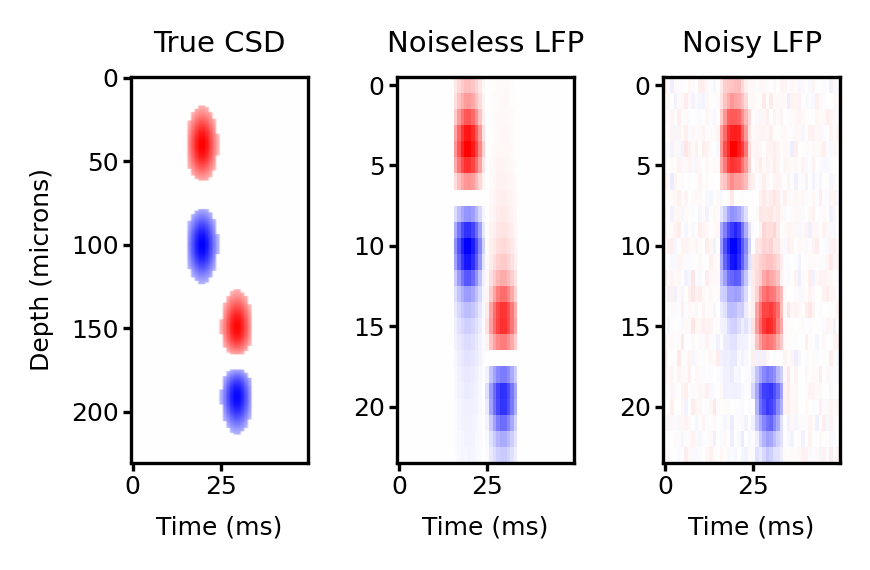

In [240]:
"""
 Simulate some data with a simple template CSD (dipole-like with one spatial dimension), 
 compare GPCSD to traditional CSD and kCSD estimation with and without noise.
 Produces Figure 1 in the paper.
"""

# %% Functions for CSD pattern and normalization
def csd_true_f(x, t):
    """
    Calculates a toy CSD mean function with two dipoles.
    :param x: desired spatial coordinates (between 0 and 24)
    :param t: desired time coordinates in milliseconds
    :return: (nx, nt) array of values
    """
    # comp1 = np.clip(150 - np.abs(x-200), 0, None) * np.clip(5 - np.abs(t.T-20), 0, None)
    # comp2 = - np.clip(150 - np.abs(x-800), 0, None) * np.clip(5 - np.abs(t.T-20), 0, None)
    # comp3 = np.clip(150 - np.abs(x-1600), 0, None) * np.clip(5 - np.abs(t.T-30), 0, None)
    # comp4 = - np.clip(150 - np.abs(x-2200), 0, None) * np.clip(5 - np.abs(t.T-30), 0, None)

    comp1 = np.exp(-(x-400)**2/(2*150**2))*np.exp(-(t.T-20)**2/(2*3**2)) 
    comp2 = -np.exp(-(x-1000)**2/(2*150**2))*np.exp(-(t.T-20)**2/(2*3**2))
    comp3 = np.exp(-(x-1500)**2/(2*150**2))*np.exp(-(t.T-30)**2/(2*3**2)) 
    comp4 = -np.exp(-(x-1900)**2/(2*150**2))*np.exp(-(t.T-30)**2/(2*3**2))
    val = comp1 + comp2 + comp3 + comp4

    val[np.abs(val) < 3e-1] = 0  # Set small values to zero
    return val/np.max(np.abs(val))

# %% Setup 
a = 0          # Top edge of electrode probe (microns)
b = 2300       # Bottom edge of electrode probe (microns)
R_true = 150   # Radius of cylinder in forward model (microns)
deltaz = 10.0   # Spacing for predictions spatially (microns)
nt = 50        # Number of time points
nx = 24        # Number of observed spatial locations for LFP
snr = 30       # noise characteristics

t = np.linspace(0, 50, nt)[:, None]
x = np.linspace(a, b, nx)[:, None]
nz = int(np.rint(b-a)/deltaz) + 1
z = np.linspace(a, b, nz)[:, None]

# %% Create true CSD
ntrial = 10
csd_true = np.repeat(csd_true_f(z, t)[:, :, None], ntrial, axis=2)
print('generated CSD of shape')
print(csd_true.shape)

# %% Create observed LFP
noiseless = np.zeros((nx, nt, ntrial))
for itrial in range(ntrial):
    noiseless[:, :, itrial] = normalize(forward_models.fwd_model_1d(csd_true[:, :, itrial], z, x, R_true))

# Add white noise to LFP
lfp = noiseless + np.random.normal(0, 0.03, size=(nx, nt, ntrial))


plt.figure(figsize=(3, 2), dpi=300)
plt.subplot(131)
plt.imshow(csd_true[:, :, 0], aspect='auto', cmap='bwr')
plt.title('True CSD')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')
plt.subplot(132)
plt.imshow(noiseless[:, :, 0], aspect='auto', cmap='bwr')
plt.title('Noiseless LFP')
plt.xlabel('Time (ms)')
plt.subplot(133)
plt.imshow(lfp[:, :, 0], aspect='auto', cmap='bwr')
plt.title('Noisy LFP')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()



In [241]:
# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 1.5  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for trial in range(lfp.shape[2]):
    for i in range(lfp.shape[0]):  # Loop over spatial dimension
        lfp_smoothed[i,:,trial] = gaussian_filter1d(lfp[i,:,trial], sigma)
lfp_flattened = lfp_smoothed.reshape(lfp_smoothed.shape[0], -1)

### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp_smoothed)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
# print(gpcsd)
gpcsd.fit(n_restarts=1)
gpcsd.predict(z, t)
# print(gpcsd)

### kCSD
kcsd = KCSD1D(x, lfp_flattened, gdx=deltaz, h=R_true)
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
lam_smooth = 10
lam_region = 0
lam_lasso = 1e-2
rcsd = rCSD.rCSD(lfp_smoothed, z, x, boundary_depth=[1000, 1500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict()
rcsd.get_difference()

Restarts: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

Eigenvalues did not converge
problem with optimization!


LinAlgError: Eigenvalues did not converge

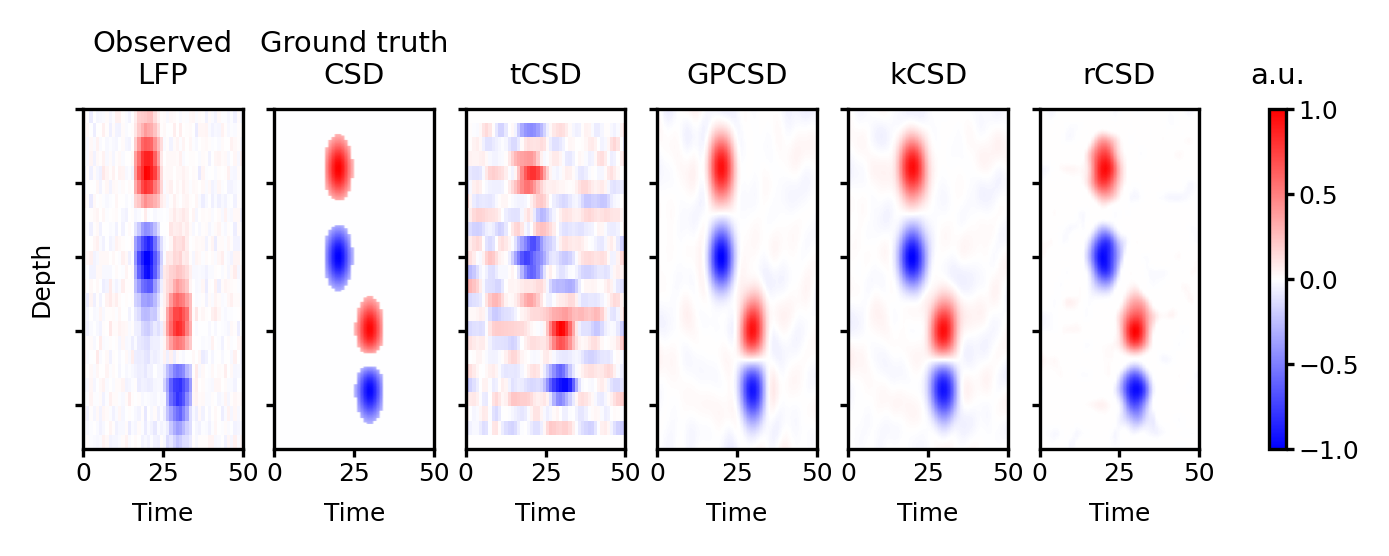

Mean Squared Errors:
tCSD:  0.018133 (sem=0.0003723055393366746)
GPCSD: 0.002045 (sem=2.1444254234091336e-05)
kCSD:  0.002358 (sem=3.0395430578795495e-05)
rCSD:  0.001761 (sem=3.0365161104000323e-05)


In [ ]:
trial_to_plot = 0

from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0.5),   # dark blue
          (0, 0, 1),     # blue
          (0, 1, 1),     # cyan
          (0, 1, 0),     # green
          (1, 1, 0),     # yellow
          (1, 0, 0),     # red
          (0.5, 0, 0)]   # dark red
positions = [0.0, 0.2, 0.48, 0.5, 0.52, 0.8, 1.0]
color_tuples = list(zip(positions, colors))
custom_jet = LinearSegmentedColormap.from_list('custom_jet', color_tuples)
# custom_jet = 'bwr'

# %% Visualize results
cmap = 'bwr'
vmlfp = np.amax(np.abs(noiseless))
vmcsd = np.amax(np.abs(normalize(csd_true)))

f = plt.figure(figsize=(6, 1.5), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)

plt.imshow(lfp[:,:,trial_to_plot], aspect='auto',
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Observed\nLFP')
plt.ylabel('Depth')
plt.xlabel('Time')
axtmp = plt.subplot(162, sharey = ax)
axtmp.set_yticklabels([])

plt.subplot(162, sharey = ax)
plt.imshow(normalize(csd_true[:,:,trial_to_plot]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('Ground truth\nCSD')
plt.xlabel('Time')

plt.subplot(163, sharey = ax)
plt.imshow(normalize(tcsd[:,:,trial_to_plot]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time')

plt.subplot(164, sharey = ax)
plt.imshow(normalize(gpcsd.csd_pred[:,:,trial_to_plot]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time')

plt.subplot(165, sharey = ax)
im = plt.imshow(normalize(kcsd_pred[:,:,trial_to_plot]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('kCSD')
plt.xlabel('Time')

plt.subplot(166, sharey = ax)
im = plt.imshow(normalize(rcsd_pred[:,:,trial_to_plot]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time')

clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()

# Save figure to PDF
f.savefig('figures/figure_1_two_dipoles.pdf', bbox_inches='tight', dpi=300)


# Calculate MSE for each method
true_csd = normalize(csd_true)
true_csd_low_res = true_csd[::10, :, :]
true_csd_flattened = true_csd.reshape(-1)
mse_tcsd = np.mean((normalize(tcsd) - true_csd_low_res) ** 2, axis=(0,1))
mse_gpcsd = np.mean((normalize(gpcsd.csd_pred) - true_csd) ** 2, axis=(0,1)) 
mse_kcsd = np.mean((normalize(kcsd_pred) - true_csd) ** 2, axis=(0,1))
mse_rcsd = np.mean((normalize(rcsd_pred) - true_csd) ** 2, axis=(0,1))

print("Mean Squared Errors:")
print(f"tCSD:  {mse_tcsd.mean():.6f} (sem={np.std(mse_tcsd)/np.sqrt(mse_tcsd.shape[0])})")
print(f"GPCSD: {mse_gpcsd.mean():.6f} (sem={np.std(mse_gpcsd)/np.sqrt(mse_gpcsd.shape[0])})") 
print(f"kCSD:  {mse_kcsd.mean():.6f} (sem={np.std(mse_kcsd)/np.sqrt(mse_kcsd.shape[0])})")
print(f"rCSD:  {mse_rcsd.mean():.6f} (sem={np.std(mse_rcsd)/np.sqrt(mse_rcsd.shape[0])})")

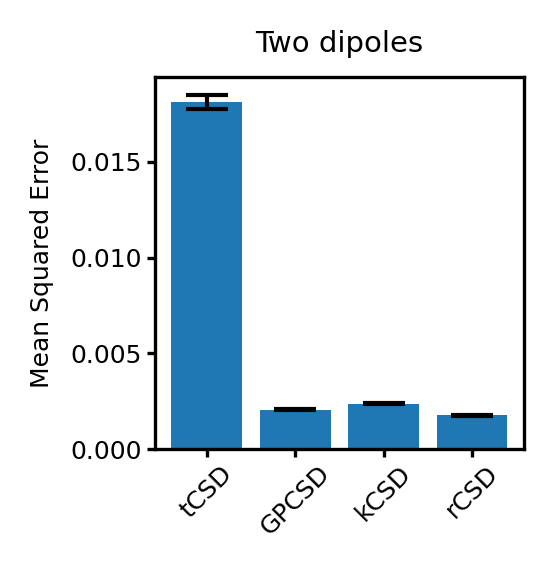

In [ ]:
# Create bar plot of MSEs with error bars
plt.figure(figsize=(2,2), dpi=300)

methods = ['tCSD', 'GPCSD', 'kCSD', 'rCSD']
mses = [mse_tcsd.mean(), mse_gpcsd.mean(), mse_kcsd.mean(), mse_rcsd.mean()]
sems = [np.std(mse_tcsd)/np.sqrt(mse_tcsd.shape[0]),
        np.std(mse_gpcsd)/np.sqrt(mse_gpcsd.shape[0]),
        np.std(mse_kcsd)/np.sqrt(mse_kcsd.shape[0]), 
        np.std(mse_rcsd)/np.sqrt(mse_rcsd.shape[0])]

plt.bar(methods, mses, yerr=sems, capsize=5)
plt.ylabel('Mean Squared Error')
plt.title('Two dipoles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

f.savefig('figures/figure_4_part1.pdf', bbox_inches='tight', dpi=300)

# Biophysical ground truth

I plot the mean in Figure 2, but use the 10 individual trials to get the values and barplot

In [ ]:
"""
 Simulate some data with a simple template CSD (dipole-like with one spatial dimension), 
 compare GPCSD to traditional CSD and kCSD estimation with and without noise.
 Produces Figure 1 in the paper.
"""
from scipy.interpolate import interp1d

# %% Setup
deltaz = 10.0   # Spacing for predictions spatially (microns)
deltax = 40.0
R_true = 200   # Radius of cylinder in forward model (microns)
a = 0          # Top edge of electrode probe (microns)
b = 880       # Bottom edge of electrode probe (microns)
nt = 101        # Number of time points
nx = 23        # Number of observed spatial locations for LFP
nz_gt = 23
t_start = 250
t_end = 250 + nt
ntrial = 10

t = np.linspace(t_start, t_end, nt)[:, None] - t_start
x = np.linspace(a, b, nx)[:, None]
z_gt = np.linspace(a, b, nz_gt)[:, None]

# %% Create true CSD
csd_data = np.load('csd_ground_truth.npy', allow_pickle=True).item()
# csd_true_gt = csd_data['all_trials'].transpose([1,2,0])[:nz_gt, t_start:t_end, :]
csd_true_gt = csd_data['trial_avg'][:nz_gt, t_start:t_end, None]
csd_true_gt = np.repeat(csd_true_gt, ntrial, axis=2)

# Interpolate csd_true to make it more dense in spatial dimension
# Create dense spatial grid (4x more dense)
z = np.linspace(z_gt[0,0], z_gt[-1,0], nz_gt*4-3)[:,None]
nz = len(z)
# Interpolate each time point and trial
csd_true = np.zeros((len(z), csd_true_gt.shape[1], csd_true_gt.shape[2]))
for time in range(csd_true.shape[1]):
    for trial in range(csd_true.shape[2]):
        f = interp1d(z_gt.flatten(), csd_true_gt[:,time,trial], kind='cubic')
        csd_true[:,time,trial] = f(z.flatten())


ntrial = csd_true.shape[2]
print('Biophysical ground truth CSD shape')
print(csd_true.shape)


# %% Create observed LFP
noiseless = np.zeros((nx, nt, ntrial))
for itrial in range(ntrial):
    noiseless[:,:,itrial] = normalize(forward_models.fwd_model_1d(csd_true[:,:,itrial], z, x, R_true))

# Add white noise to LFP
lfp = noiseless + np.random.normal(0, 0.03, size=(nx, nt, ntrial))

Biophysical ground truth CSD shape
(89, 101, 10)


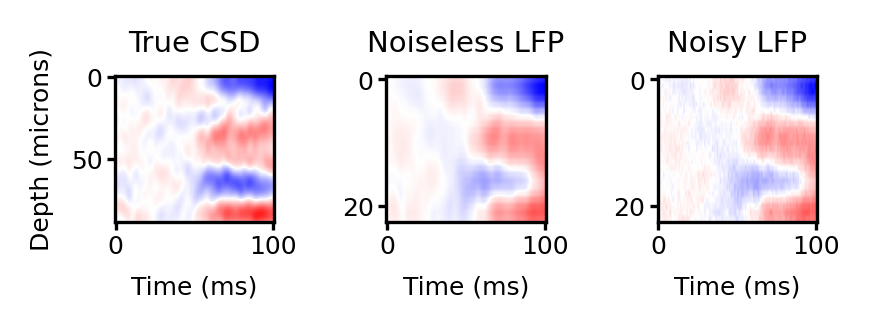

In [ ]:
plot_trial = 0
cmap = 'bwr'

plt.figure(figsize=(3, 1.2), dpi=300)
plt.subplot(131)
to_plot = csd_true[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap=cmap,
                vmin=-1*maximum, vmax=1*maximum)
plt.title('True CSD')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')
plt.subplot(132)
to_plot = noiseless[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap=cmap,
                vmin=-maximum, vmax=maximum)
plt.title('Noiseless LFP')
plt.xlabel('Time (ms)')
plt.subplot(133)
to_plot = lfp[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap=cmap,
                vmin=-maximum, vmax=maximum)
plt.title('Noisy LFP')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

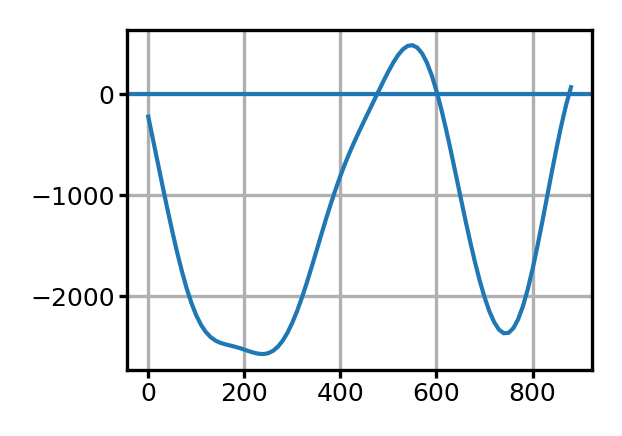

In [ ]:
plt.subplots(figsize=(2,1.5), dpi=300)
plt.plot(z, np.cumsum(csd_true.mean(axis=(1,2))))
plt.axhline(0)
plt.grid(True)

In [ ]:
# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)

### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
# print(gpcsd)
gpcsd.fit(n_restarts=10)
gpcsd.predict(z, t)
# print(gpcsd)

### kCSD
lfp_flattened = lfp_smoothed.reshape(lfp_smoothed.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=deltaz, h=R_true)
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
lam_smooth = 5
lam_region = 1e-2
lam_lasso = 1e-2
rcsd = rCSD.rCSD(lfp_smoothed, z, x, boundary_depth=[500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()


Restarts: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 100.0 6.812920690579615


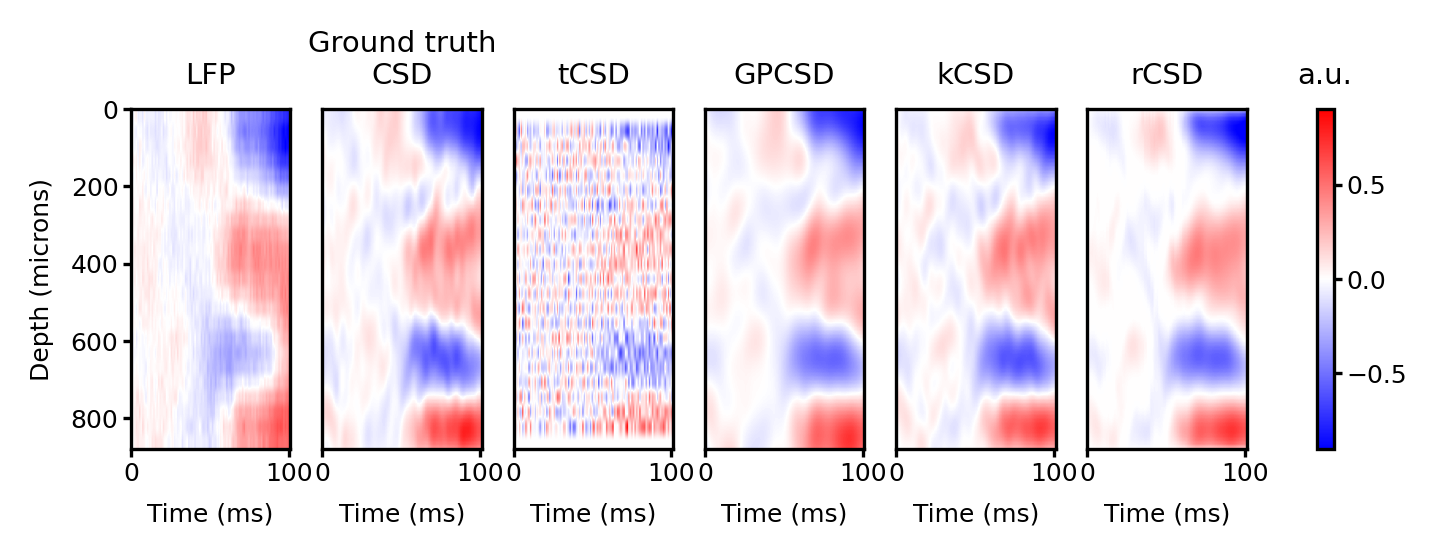

Mean Squared Errors:
tCSD:  0.078727 (sem=0.0022363792241832945)
GPCSD: 0.001794 (sem=5.073908019163233e-05)
kCSD:  0.002890 (sem=6.421508029353335e-05)
rCSD:  0.005112 (sem=0.00010560297683396823)


In [ ]:
# %% Visualize results
plot_trial = 0
cmap = 'bwr'
vmlfp = np.amax(np.abs(noiseless))
vmcsd = np.amax(np.abs(normalize(csd_true[:,:,plot_trial])))

f = plt.figure(figsize=(6, 1.5), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)
plt.imshow(lfp[:,:,plot_trial], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('LFP')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')

plt.subplot(162, sharey=ax)
plt.imshow(normalize(csd_true[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('Ground truth\nCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(163, sharey=ax)
plt.imshow(normalize(tcsd[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(164, sharey=ax)
plt.imshow(normalize(gpcsd.csd_pred[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(165, sharey=ax)
im = plt.imshow(normalize(kcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('kCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(166, sharey=ax)
im = plt.imshow(normalize(rcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-0.9, vmax=0.9, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)


clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()

f.savefig('figures/figure_2_biological_ground_truth.pdf', bbox_inches='tight', dpi=300)

# Calculate MSE for each method
true_csd = normalize(csd_true)
true_csd_low_res = normalize(csd_true_gt)
true_csd_flattened = true_csd.reshape(-1)
mse_tcsd = np.mean((normalize(tcsd) - true_csd_low_res) ** 2, axis=(0,1))
mse_gpcsd = np.mean((normalize(gpcsd.csd_pred) - true_csd) ** 2, axis=(0,1)) 
mse_kcsd = np.mean((normalize(kcsd_pred) - true_csd) ** 2, axis=(0,1))
mse_rcsd = np.mean((normalize(rcsd_pred) - true_csd) ** 2, axis=(0,1))

print("Mean Squared Errors:")
print(f"tCSD:  {mse_tcsd.mean():.6f} (sem={np.std(mse_tcsd)/np.sqrt(mse_tcsd.shape[0])})")
print(f"GPCSD: {mse_gpcsd.mean():.6f} (sem={np.std(mse_gpcsd)/np.sqrt(mse_gpcsd.shape[0])})") 
print(f"kCSD:  {mse_kcsd.mean():.6f} (sem={np.std(mse_kcsd)/np.sqrt(mse_kcsd.shape[0])})")
print(f"rCSD:  {mse_rcsd.mean():.6f} (sem={np.std(mse_rcsd)/np.sqrt(mse_rcsd.shape[0])})")


In [ ]:
lam_smooth = 30
lam_region = 1e-2
lam_lasso = 0.5e-1
results = np.zeros((5, 5))
true_csd = normalize(csd_true)

for i, lam_smooth in enumerate([1, 3, 10, 30, 100]):
    for j, lam_lasso in enumerate([0, 1e-3, 3e-3, 1e-2, 3e-2]):
        rcsd = rCSD.rCSD(lfp_smoothed, z, x, boundary_depth=[500], 
                        R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
        rcsd_pred = rcsd.predict(parallel=False)
        mse_rcsd = np.mean((normalize(rcsd_pred) - true_csd) ** 2)
        results[i, j] = mse_rcsd

print(results)

[[0.00986596 0.00797195 0.00674482 0.00815469 0.01344151]
 [0.0080329  0.00681788 0.00645486 0.0071737  0.0104332 ]
 [0.00791893 0.00762999 0.00753789 0.00786897 0.00963806]
 [0.00997727 0.00994359 0.00993287 0.01006672 0.01083965]
 [0.01546292 0.01546982 0.01546494 0.0154598  0.01573161]]


# Sparse biophysical ground truth

In [ ]:
"""
 Simulate some data with a simple template CSD (dipole-like with one spatial dimension), 
 compare GPCSD to traditional CSD and kCSD estimation with and without noise.
 Produces Figure 1 in the paper.
"""
from scipy.interpolate import interp1d

# %% Setup
deltaz = 10.0   # Spacing for predictions spatially (microns)
deltax = 40.0
R_true = 200   # Radius of cylinder in forward model (microns)
a = 0          # Top edge of electrode probe (microns)
b = 880       # Bottom edge of electrode probe (microns)
nt = 101        # Number of time points
nx = 23        # Number of observed spatial locations for LFP
nz_gt = 23
t_start = 250
t_end = 250 + nt
ntrial = 5

t = np.linspace(t_start, t_end, nt)[:, None] - t_start
x = np.linspace(a, b, nx)[:, None]
z_gt = np.linspace(a, b, nz_gt)[:, None]

# %% Create true CSD
csd_data = np.load('csd_ground_truth.npy', allow_pickle=True).item()
# csd_true_gt = csd_data['all_trials'].transpose([1,2,0])[:nz_gt, t_start:t_end, :]
csd_true_gt = csd_data['trial_avg'][:nz_gt, t_start:t_end, None]
csd_true_gt = np.repeat(csd_true_gt, ntrial, axis=2)

# Interpolate csd_true to make it more dense in spatial dimension
# Create dense spatial grid (4x more dense)
z = np.linspace(z_gt[0,0], z_gt[-1,0], nz_gt*4-3)[:,None]
nz = len(z)
# Interpolate each time point and trial
csd_true = np.zeros((len(z), csd_true_gt.shape[1], csd_true_gt.shape[2]))
for time in range(csd_true.shape[1]):
    for trial in range(csd_true.shape[2]):
        f = interp1d(z_gt.flatten(), csd_true_gt[:,time,trial], kind='cubic')
        csd_true[:,time,trial] = f(z.flatten())

# Cut off smaller CSD values to create sparse CSD
# Cut off CSD values below threshold to create sparsity for each time point
for tt in range(csd_true.shape[1]):
    # threshold = np.quantile(np.abs(csd_true[:, tt, :]), 0.3)
    threshold = 0.3*np.max(np.abs(csd_true[:, tt, :]))
    mask = np.abs(csd_true[:, tt, :]) < threshold
    csd_true[:, tt, :][mask] = 0
    # Amplify remaining values by 1.5x to counter the removal
    # Calculate amplification factor based on ratio of total signal before/after thresholding
    total_before = np.sum(np.abs(csd_true[:, tt, :]))
    total_after = np.sum(np.abs(csd_true[:, tt, :][~mask]))
    amp_factor = total_before / total_after if total_after > 0 else 1.0
    csd_true[:, tt, :][~mask] *= amp_factor
    


ntrial = csd_true.shape[2]
print('Biophysical ground truth CSD shape')
print(csd_true.shape)


# %% Create observed LFP
noiseless = np.zeros((nx, nt, ntrial))
for itrial in range(ntrial):
    noiseless[:,:,itrial] = normalize(forward_models.fwd_model_1d(csd_true[:,:,itrial], z, x, R_true))

# Add white noise to LFP
lfp = noiseless + np.random.normal(0, 0.03, size=(nx, nt, ntrial))

Biophysical ground truth CSD shape
(89, 101, 5)


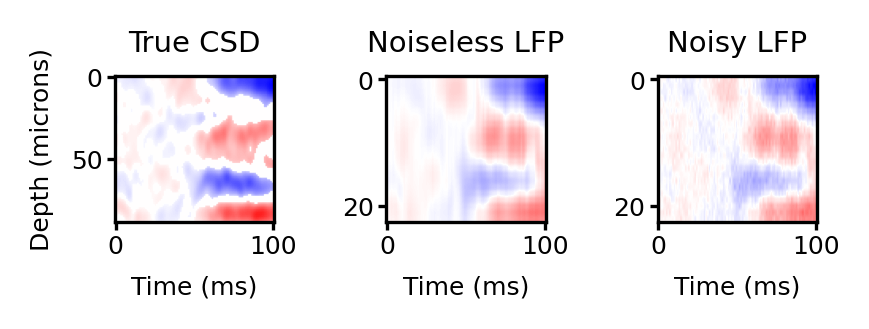

In [ ]:
plot_trial = 0
cmap = 'bwr'

plt.figure(figsize=(3, 1.2), dpi=300)
plt.subplot(131)
to_plot = csd_true[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap=cmap,
                vmin=-1*maximum, vmax=1*maximum)
plt.title('True CSD')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')
plt.subplot(132)
to_plot = noiseless[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap=cmap,
                vmin=-maximum, vmax=maximum)
plt.title('Noiseless LFP')
plt.xlabel('Time (ms)')
plt.subplot(133)
to_plot = lfp[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap=cmap,
                vmin=-maximum, vmax=maximum)
plt.title('Noisy LFP')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

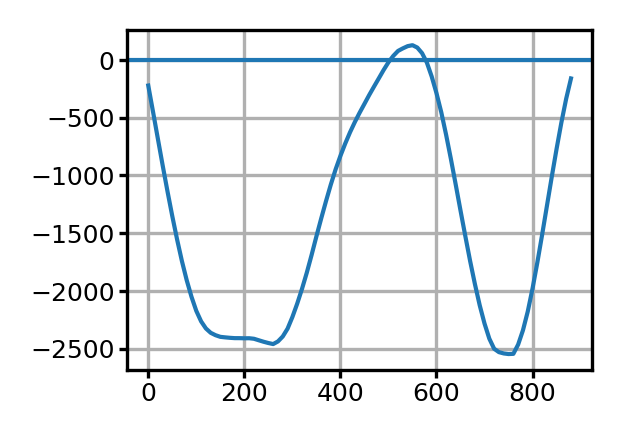

In [ ]:
plt.subplots(figsize=(2,1.5), dpi=300)
plt.plot(z, np.cumsum(csd_true.mean(axis=(1,2))))
plt.axhline(0)
plt.grid(True)

In [ ]:
# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)

### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
# print(gpcsd)
gpcsd.fit(n_restarts=1)
gpcsd.predict(z, t)
# print(gpcsd)

### kCSD
lfp_flattened = lfp_smoothed.reshape(lfp_smoothed.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=deltaz, h=R_true)
kcsd.cross_validate(Rs=np.linspace(100, 800, 5), lambdas=np.logspace(4,-15,25,base=5.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
lam_smooth = 5
lam_region = 1e-2
lam_lasso = 1e-2
rcsd = rCSD.rCSD(lfp_smoothed, z, x, boundary_depth=[500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()


Restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Restarts: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 275.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 625.0
Cross validating R (all lambda) : 800.0
R, lambda : 100.0 3.823622456658651


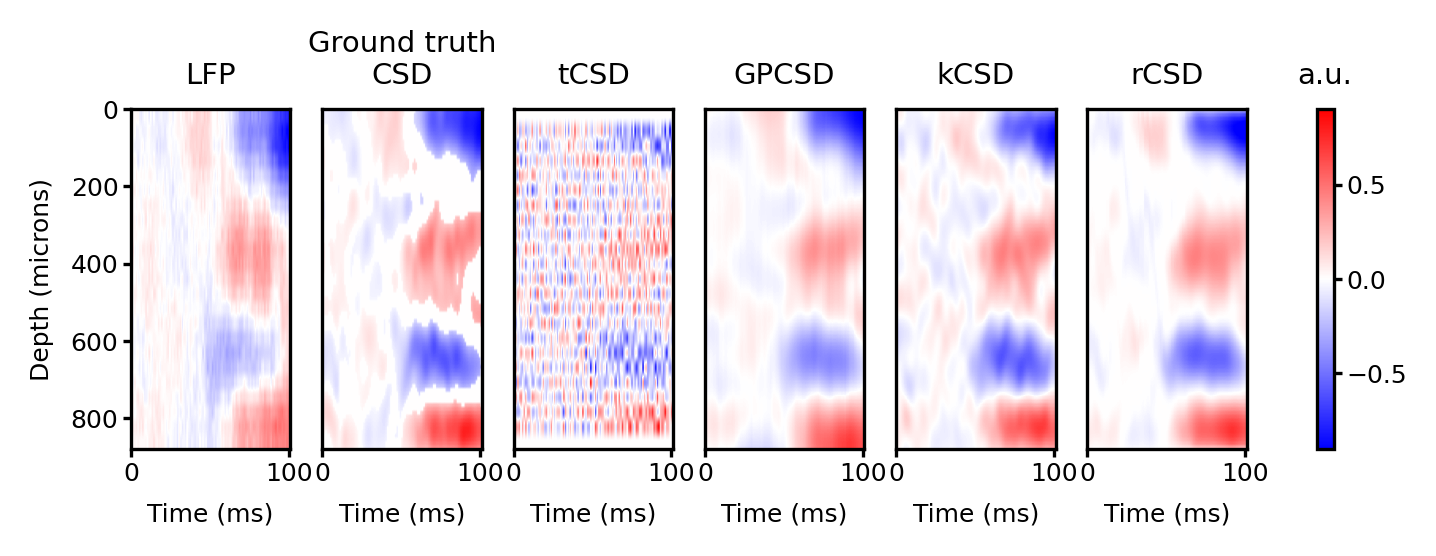

Mean Squared Errors:
tCSD:  0.088965 (sem=0.001715367849744768)
GPCSD: 0.005716 (sem=0.0002548123547921535)
kCSD:  0.004899 (sem=0.00010460656967724671)
rCSD:  0.006234 (sem=0.00011219849595669875)


In [ ]:
# %% Visualize results
plot_trial = 0
cmap = 'bwr'
vmlfp = np.amax(np.abs(noiseless))
vmcsd = np.amax(np.abs(normalize(csd_true[:,:,plot_trial])))

f = plt.figure(figsize=(6, 1.5), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)
plt.imshow(lfp[:,:,plot_trial], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('LFP')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')

plt.subplot(162, sharey=ax)
plt.imshow(normalize(csd_true[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('Ground truth\nCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(163, sharey=ax)
plt.imshow(normalize(tcsd[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(164, sharey=ax)
plt.imshow(normalize(gpcsd.csd_pred[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(165, sharey=ax)
im = plt.imshow(normalize(kcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('kCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(166, sharey=ax)
im = plt.imshow(normalize(rcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-0.9, vmax=0.9, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time (ms)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)


clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()

f.savefig('figures/supplement_figure_sparse_biological_ground_truth.pdf', bbox_inches='tight', dpi=300)

# Calculate MSE for each method
true_csd = normalize(csd_true)
true_csd_low_res = normalize(csd_true_gt)
true_csd_flattened = true_csd.reshape(-1)
mse_tcsd = np.mean((normalize(tcsd) - true_csd_low_res) ** 2, axis=(0,1))
mse_gpcsd = np.mean((normalize(gpcsd.csd_pred) - true_csd) ** 2, axis=(0,1)) 
mse_kcsd = np.mean((normalize(kcsd_pred) - true_csd) ** 2, axis=(0,1))
mse_rcsd = np.mean((normalize(rcsd_pred) - true_csd) ** 2, axis=(0,1))

print("Mean Squared Errors:")
print(f"tCSD:  {mse_tcsd.mean():.6f} (sem={np.std(mse_tcsd)/np.sqrt(mse_tcsd.shape[0])})")
print(f"GPCSD: {mse_gpcsd.mean():.6f} (sem={np.std(mse_gpcsd)/np.sqrt(mse_gpcsd.shape[0])})") 
print(f"kCSD:  {mse_kcsd.mean():.6f} (sem={np.std(mse_kcsd)/np.sqrt(mse_kcsd.shape[0])})")
print(f"rCSD:  {mse_rcsd.mean():.6f} (sem={np.std(mse_rcsd)/np.sqrt(mse_rcsd.shape[0])})")


# Experimental data

In [44]:
# Load experimental data
data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322749.npy', allow_pickle=True)
V1 = data.item()  # Convert from np.ndarray to dict
# locationA, aligned_lfp3d, mean_lfp, aligned_lfp, structure_acronyms, intervals

lfp = V1['aligned_lfp3d'].values.transpose((0, 2, 1))
# lfp = lfp.mean(axis=2)[:, :, None]


ntrial = 10
x = V1['locationA'][:, 0]      # LFP spatial locations , microns
x = x[:, None]
nx = len(x)
# CSD spatial locations , microns
z = x
nz = nx

# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)
lfp = lfp_smoothed[:, :, :ntrial]

nt = lfp.shape[1]
t = np.arange(nt)
t = t[:, None]

lfp = normalize(lfp)
lfp.shape

(93, 100, 10)

In [45]:
V1['intervals'], V1['structure_acronyms']

(array([ 0,  3,  9, 20, 38, 48, 61, 85, 93]),
 array(['MGm', 'SGN', 'LP', 'DG', 'ProS', 'SUB', 'VISp', nan], dtype=object))

In [53]:
### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### failed GPCSD
gpcsd = GPCSD1D(lfp, x, t)
gpcsd.fit(n_restarts=10)
# gpcsd.R['value'] = 150
# gpcsd.spatial_cov.params['ell']['value'] = 200
gpcsd.predict(z, t)
gpcsd_pred_failed = gpcsd.csd_pred

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
gpcsd.fit(n_restarts=10)
gpcsd.R['value'] = 150
gpcsd.spatial_cov.params['ell']['value'] = 200
gpcsd.predict(z, t)
gpcsd_pred = gpcsd.csd_pred

### kCSD
lfp_flattened = lfp.reshape(lfp.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=(z[1]-z[0]))
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
R_true = 150
lam_smooth = 1
lam_region = 1e-2
lam_lasso = 0.3e-1
rcsd = rCSD.rCSD(lfp, z, x, boundary_depth=[860, 2500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()


Restarts: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 200.0 5.108969774506935e-07


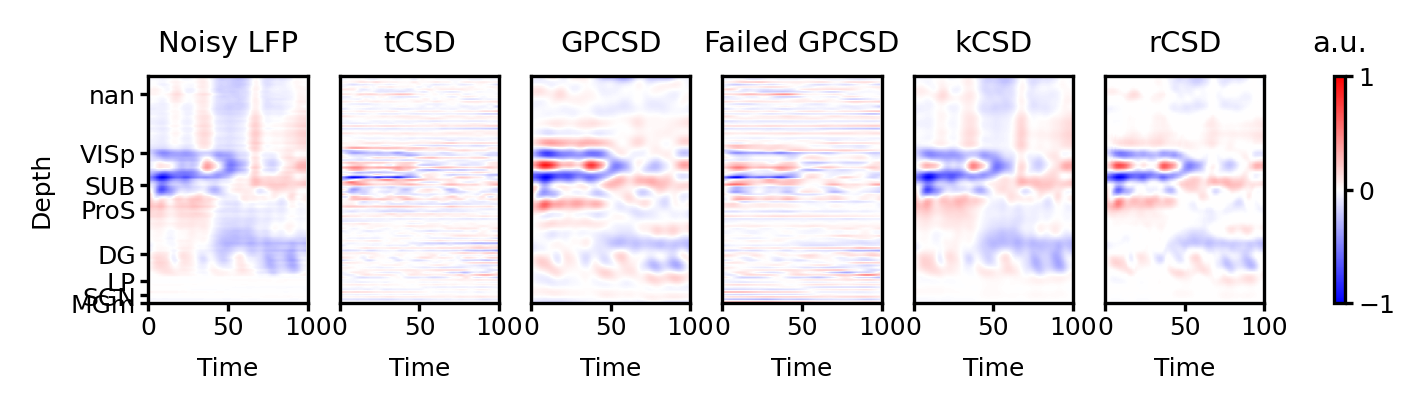

In [54]:
# %% Visualize results
plot_trial = 5
cmap = 'bwr'
vmlfp = np.amax(np.abs(lfp))
vmcsd = np.amax(np.abs(normalize(gpcsd.csd_pred[:,:,plot_trial])))

f = plt.figure(figsize=(6, 1), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)
plt.imshow(lfp[:,:,plot_trial], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, 
           extent=[t[0, 0], t[-1, 0], x[0, 0], x[-1, 0]])  # Swapped x[0,0] and x[-1,0]
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')
plt.xticks([0, 50, 100])

# Add area names
plt.yticks(x[V1['intervals'][:-1]].flatten(), V1['structure_acronyms'])

plt.subplot(162, sharey = ax)
plt.imshow(normalize(tcsd[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[0, 0], x[-1, 0]])  # Swapped x[0,0] and x[-1,0]
plt.title('tCSD')
plt.xlabel('Time')
plt.xticks([0, 50, 100])
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(163, sharey = ax)
plt.imshow(normalize(gpcsd.csd_pred[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[0, 0], z[-1, 0]])  # Swapped z[0,0] and z[-1,0]
plt.title('GPCSD')
plt.xlabel('Time')
plt.xticks([0, 50, 100])
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(164, sharey = ax)
plt.imshow(normalize(gpcsd_pred_failed[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[0, 0], z[-1, 0]])  # Swapped z[0,0] and z[-1,0]
plt.title('Failed GPCSD')
plt.xlabel('Time')
plt.xticks([0, 50, 100])
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(165, sharey = ax)
im = plt.imshow(normalize(kcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[0, 0], z[-1, 0]])  # Swapped z[0,0] and z[-1,0]
plt.title('kCSD')
plt.xlabel('Time')
plt.xticks([0, 50, 100])
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.subplot(166, sharey = ax)
im = plt.imshow(normalize(rcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-0.9, vmax=0.9, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[0, 0], z[-1, 0]])  # Swapped z[0,0] and z[-1,0]
plt.title('rCSD')
plt.xlabel('Time')
plt.xticks([0, 50, 100])
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

clb = f.colorbar(im, ax=f.axes, ticks=[-1, 0, 1])
im.set_clim([-1, 1])
clb.ax.set_title('a.u.')
plt.show()

f.savefig('figures/figure_3_allen.pdf', bbox_inches='tight', dpi=300)

## Cross-validation


In [ ]:
def get_min_mse(pred, target):
    """Scale pred to minimize MSE with target.
    
    Args:
        pred: array or matrix to be scaled
        target: array or matrix to compare against
        
    Returns:
        float: Minimum MSE after optimal scaling
    """
    # Reshape inputs to 1D arrays
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    # Calculate optimal scaling factor using dot product
    scale = np.sum(pred_flat * target_flat) / np.sum(pred_flat * pred_flat)
    
    # Calculate MSE with optimal scaling
    mse = np.mean((scale * pred_flat - target_flat) ** 2)
    
    return mse


In [ ]:
rep = 10
del_electrode_list = np.random.choice(range(1, nx-1), rep, replace=False)

# GPCSD
gpcsd_hp = gpcsd.extract_model_params()
gpcsd_errors = []
lfp_pred_rcd_gpcsd = np.zeros_like(lfp)
for del_electrode in tqdm(del_electrode_list):
    x_temp = np.delete(x, del_electrode, axis=0)
    Y_temp = np.delete(lfp, del_electrode, axis=0)
    gpcsd = GPCSD1D(Y_temp, x_temp, t)
    # gpcsd.restore_model_params(gpcsd_hp)
    gpcsd.fit(n_restarts=10)
    gpcsd.predict(z, t)
    csd_temp = gpcsd.csd_pred
    A = b_fwd_1d(z.T-x, gpcsd.R['value'])
    lfp_pred = normalize(np.einsum('xz,ztm->xtm', A, csd_temp))
    lfp_pred_rcd_gpcsd[del_electrode, :, :] = lfp_pred[del_electrode, :, :]
    # gpcsd_errors.append(np.mean((lfp[del_electrode, :, :] - lfp_pred[del_electrode, :, :] )**2))
    gpcsd_errors.append(get_min_mse(lfp_pred[del_electrode, :, :], lfp[del_electrode, :, :]))

# kCSD
kcsd_hp = [kcsd.R, 1e-5]
kcsd_errors = []
lfp_pred_rcd_kcsd = np.zeros_like(lfp)
for del_electrode in tqdm(del_electrode_list):
    x_temp = np.delete(x, del_electrode, axis=0)
    Y_temp = np.delete(lfp_flattened, del_electrode, axis=0)
    kcsd = KCSD1D(x_temp, Y_temp, gdx=(z[1]-z[0]))
    # kcsd.R, kcsd.lambd = kcsd_hp
    kcsd.cross_validate(Rs=np.linspace(100, 800, 10), lambdas=np.logspace(4,-15,15,base=10.))
    csd_temp = kcsd.values().reshape((nz, nt, ntrial))
    A = b_fwd_1d(z.T-x, kcsd.R)
    lfp_pred = normalize(np.einsum('xz,ztm->xtm', A, csd_temp))
    lfp_pred_rcd_kcsd[del_electrode, :, :] = lfp_pred[del_electrode, :, :]
    # kcsd_errors.append(np.mean((lfp[del_electrode, :, :] - lfp_pred[del_electrode, :, :] )**2))
    kcsd_errors.append(get_min_mse(lfp_pred[del_electrode, :, :], lfp[del_electrode, :, :]))

  0%|          | 0/10 [00:00<?, ?it/s]

Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 10%|█         | 1/10 [00:09<01:29,  9.95s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 20%|██        | 2/10 [00:16<01:03,  7.94s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 30%|███       | 3/10 [00:22<00:49,  7.00s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 40%|████      | 4/10 [00:26<00:36,  6.06s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 50%|█████     | 5/10 [00:30<00:25,  5.10s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 60%|██████    | 6/10 [00:33<00:18,  4.55s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 70%|███████   | 7/10 [00:37<00:12,  4.14s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 80%|████████  | 8/10 [00:40<00:08,  4.04s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 90%|█████████ | 9/10 [00:45<00:04,  4.09s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


100%|██████████| 10/10 [00:48<00:00,  4.89s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07


In [ ]:
rcsd_errors, lfp_pred_rcd_rcsd = rcsd.cv_electrode(del_electrode_list=del_electrode_list, return_pred=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:36<00:00,  9.67s/it]


In [ ]:
print(f"kCSD error: {np.mean(kcsd_errors):.4f} ({np.std(kcsd_errors):.4f})")
print(f"GPCSD error: {np.mean(gpcsd_errors):.4f} ({np.std(gpcsd_errors):.4f})")
print(f"rCSD error: {np.mean(rcsd_errors):.4f} ({np.std(rcsd_errors):.4f})")

(0.010266153424426301, 0.0014544276913016766, 0.008169143448546648)

In [ ]:
del_electrode_list

array([49,  8, 62, 24, 18, 61, 58, 16, 26,  7])

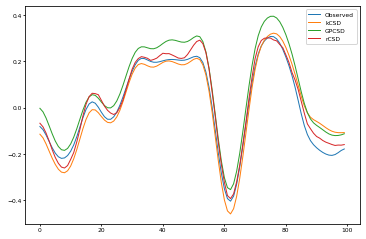

In [ ]:
electrode_to_plot = 8
trial_to_plot = 5

plt.plot(lfp[electrode_to_plot, :, trial_to_plot], label='Observed')
plt.plot(0.7*lfp_pred_rcd_kcsd[electrode_to_plot, :, trial_to_plot], label='kCSD')
plt.plot(lfp_pred_rcd_gpcsd[electrode_to_plot, :, trial_to_plot], label='GPCSD')
plt.plot(lfp_pred_rcd_rcsd[electrode_to_plot, :, trial_to_plot], label='rCSD')
plt.legend()
plt.show()

In [ ]:
dic = rcsd.get_hp_dic()
rcsd.cv_para("R", [50, 100, 200], dic)

100%|██████████| 3/3 [06:32<00:00, 130.88s/it]


([0.002968233994210923, 0.00916925282702601, 0.0027936651391279595],
 [2.9572756990156037e-06, 8.779839490928737e-05, 1.5272182110509563e-06])

# Correlation matrix

In [65]:
# Load experimental data
data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322749.npy', allow_pickle=True)
V1 = data.item()  # Convert from np.ndarray to dict
# locationA, aligned_lfp3d, mean_lfp, aligned_lfp, structure_acronyms, intervals

lfp = V1['aligned_lfp3d'].values.transpose((0, 2, 1))
# lfp = lfp.mean(axis=2)[:, :, None]


ntrial = 150
x = V1['locationA'][:, 0]      # LFP spatial locations , microns
x = x[:, None]
nx = len(x)
# CSD spatial locations , microns
z = x
nz = nx

# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)
lfp = lfp_smoothed[:, :, :ntrial]

nt = lfp.shape[1]
t = np.arange(nt)
t = t[:, None]

lfp = normalize(lfp)

### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
gpcsd.fit(n_restarts=10)
gpcsd.R['value'] = 150
gpcsd.spatial_cov.params['ell']['value'] = 200
gpcsd.predict(z, t)
gpcsd_pred = gpcsd.csd_pred

### kCSD
lfp_flattened = lfp.reshape(lfp.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=(z[1]-z[0]))
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
R_true = 150
lam_smooth = 1
lam_region = 1e-2
lam_lasso = 0.3e-1
rcsd = rCSD.rCSD(lfp, z, x, boundary_depth=[860, 2500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()

# Collect all LFP and CSD predictions in a dictionary
V1_results = {
    'z': z,
    'lfp': lfp,
    'tcsd': tcsd,
    'gpcsd': gpcsd_pred,
    'kcsd': kcsd_pred,
    'rcsd': rcsd_pred
}


Restarts: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 150.0 5.108969774506935e-07


In [ ]:
# Load experimental data
data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322751.npy', allow_pickle=True)
LM = data.item()  # Convert from np.ndarray to dict
# locationA, aligned_lfp3d, mean_lfp, aligned_lfp, structure_acronyms, intervals


lfp = LM['aligned_lfp3d'].values.transpose((0, 2, 1))
# lfp = lfp.mean(axis=2)[:, :, None]


ntrial = 150
x = LM['locationA'][:, 0]      # LFP spatial locations , microns
x = x[:, None]
nx = len(x)
# CSD spatial locations , microns
z = x
nz = nx

# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)
lfp = lfp_smoothed[:, :, :ntrial]

nt = lfp.shape[1]
t = np.arange(nt)
t = t[:, None]

lfp = normalize(lfp)

### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
gpcsd.fit(n_restarts=10)
gpcsd.R['value'] = 150
gpcsd.spatial_cov.params['ell']['value'] = 200
gpcsd.predict(z, t)
gpcsd_pred = gpcsd.csd_pred

### kCSD
lfp_flattened = lfp.reshape(lfp.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=(z[1]-z[0]))
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
R_true = 150
lam_smooth = 1
lam_region = 1e-2
lam_lasso = 0.3e-1
rcsd = rCSD.rCSD(lfp, z, x, boundary_depth=[860, 2500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()

# Collect all LFP and CSD predictions in a dictionary
LM_results = {
    'z': z,
    'lfp': lfp,
    'tcsd': tcsd,
    'gpcsd': gpcsd_pred,
    'kcsd': kcsd_pred,
    'rcsd': rcsd_pred
}


Restarts: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 200.0 5.108969774506935e-07


In [68]:
method = 'gpcsd'
v1_data = V1_results[method].reshape(V1_results[method].shape[0], -1)
lm_data = LM_results[method].reshape(LM_results[method].shape[0], -1)

# Calculate correlation matrix between V1 and LM
cross_corr = np.corrcoef(v1_data, lm_data)

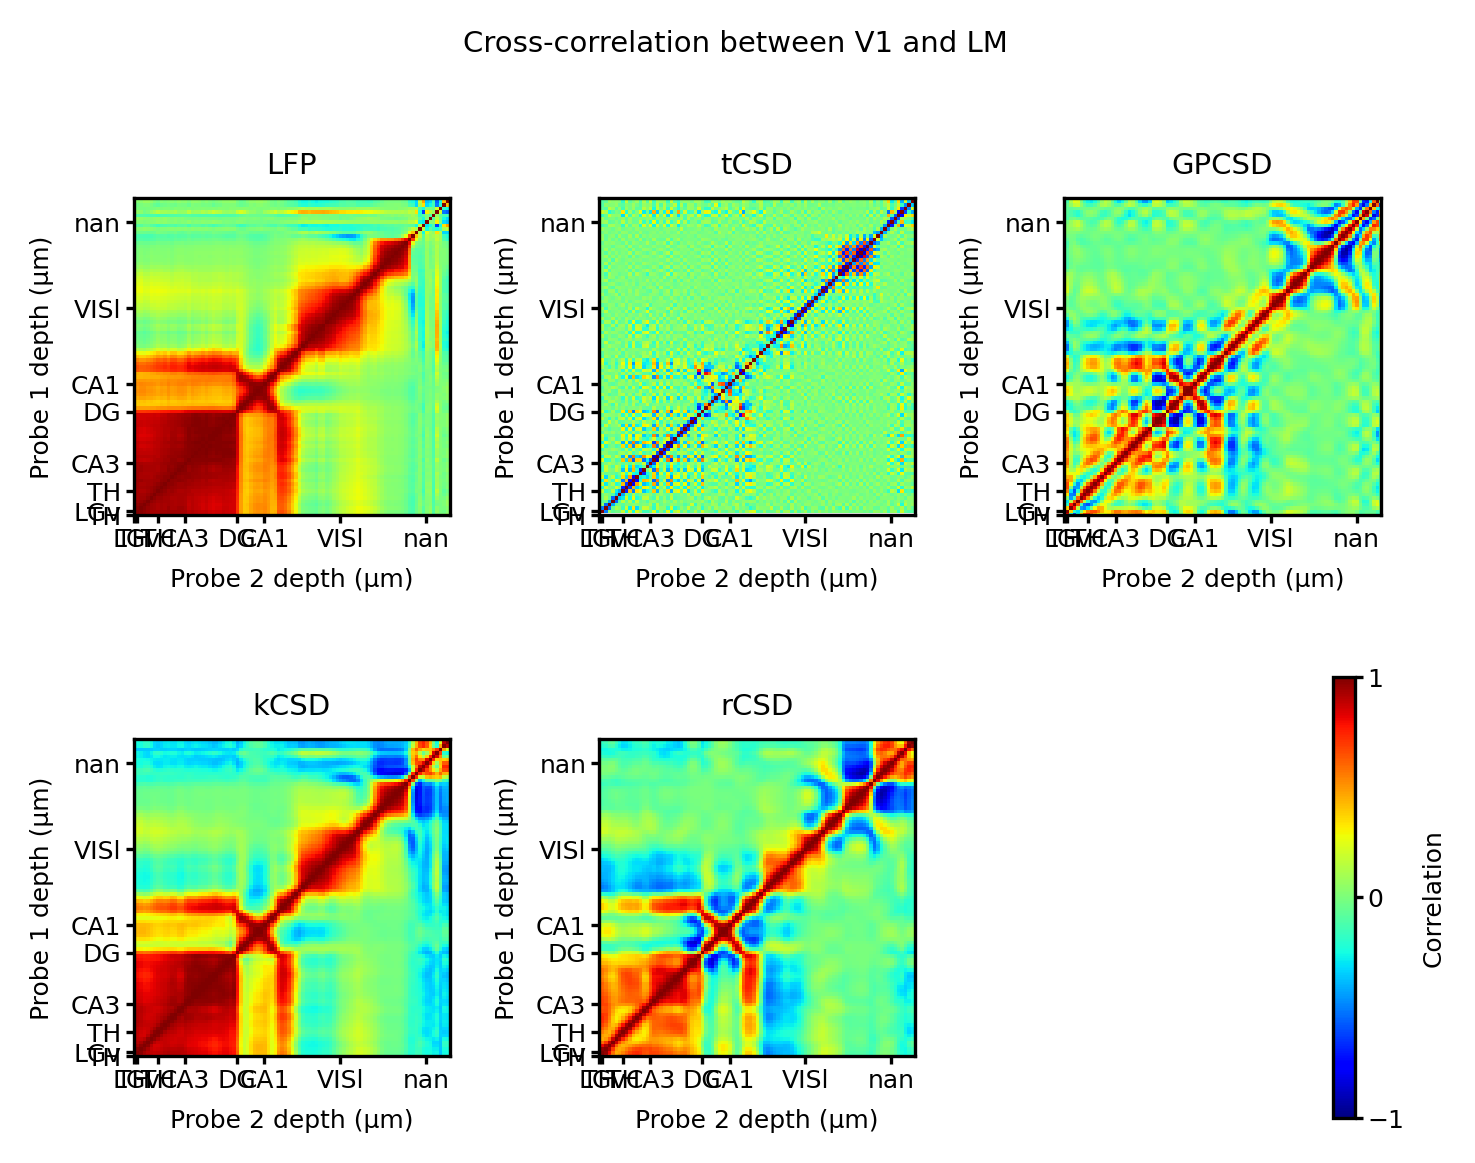

In [85]:
# Calculate cross-correlation between V1 and LM
utils.use_pdf_plot()

fig, axes = plt.subplots(2, 3, figsize=(5, 4), dpi=300)
fig.suptitle('Cross-correlation between V1 and LM')

methods = ['lfp', 'tcsd', 'gpcsd', 'kcsd', 'rcsd']
titles = ['LFP', 'tCSD', 'GPCSD', 'kCSD', 'rCSD']

for i, (method, title) in enumerate(zip(methods, titles)):
    # Reshape data to 2D (channels x (time*trials))
    v1_data = V1_results[method].reshape(V1_results[method].shape[0], -1)
    lm_data = LM_results[method].reshape(LM_results[method].shape[0], -1)
    
    # Calculate correlation matrix between V1 and LM
    cross_corr = np.corrcoef(v1_data, lm_data)
    # cross_corr /= np.abs(cross_corr).max()
    
    # Plot correlation matrix
    row = i // 3
    col = i % 3
    im = axes[row, col].imshow(cross_corr, cmap='jet', vmin=-1, vmax=1)
    axes[row, col].set_xlim(0, len(LM_results["z"])-1)
    axes[row, col].set_ylim(0, len(V1_results["z"])-1)

    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Probe 2 depth (μm)')
    axes[row, col].set_xticks(LM['intervals'][:-1].flatten())
    axes[row, col].set_xticklabels(LM['structure_acronyms'])
    axes[row, col].set_ylabel('Probe 1 depth (μm)')
    axes[row, col].set_yticks(V1['intervals'][:-1].flatten())
    axes[row, col].set_yticklabels(V1['structure_acronyms'])



# Hide the empty subplot
axes[1, 2].axis('off')
cbar = fig.colorbar(im, ax=axes[1,2], label='Correlation', ticks=[-1, 0, 1])


plt.tight_layout()
plt.show()

f.savefig('figures/figure_4_allen_corr.pdf', bbox_inches='tight', dpi=300)

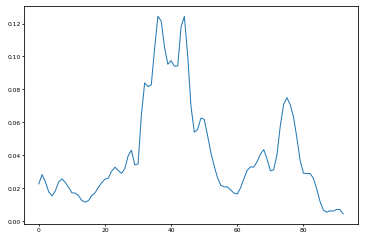

In [29]:
plt.plot(V1_results['rcsd'].std(axis=(1,2)))

In [17]:
ntrial = 150
results_dict = {}
cross_corr_dict = {}

for probe in ['V1', 'LM']:
    if probe == 'V1':
        data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322749.npy', allow_pickle=True)
    else:
        data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322751.npy', allow_pickle=True)

    data = data.item()  # Convert from np.ndarray to dict

    lfp = data['aligned_lfp3d'].values.transpose((0, 2, 1))
    # lfp = lfp.mean(axis=2)[:, :, None]

    x = data['locationA'][:, 0]      # LFP spatial locations , microns
    x = x[:, None]
    nx = len(x)
    # CSD spatial locations , microns
    z = x
    nz = nx

    # Smooth LFP along time axis using Gaussian filter
    from scipy.ndimage import gaussian_filter1d
    sigma = 2  # Adjust smoothing amount by changing sigma
    lfp_smoothed = np.zeros_like(lfp)
    for i in range(lfp.shape[0]):  # Loop over spatial dimension
        for j in range(lfp.shape[2]):  # Loop over trials
            lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)
    lfp_smoothed = normalize(lfp_smoothed)
    lfp = lfp_smoothed[:, :, :ntrial]

    nt = lfp.shape[1]
    t = np.arange(nt)
    t = t[:, None]

    ### tCSD
    tcsd = predict_csd.predictcsd_trad_1d(lfp)

    ### GPCSD
    gpcsd = GPCSD1D(lfp, x, t)
    gpcsd.fit(n_restarts=10)
    gpcsd.R['value'] = 150
    gpcsd.spatial_cov.params['ell']['value'] = 200
    gpcsd.predict(z, t)
    gpcsd_pred = gpcsd.csd_pred

    ### kCSD
    lfp_flattened = lfp.reshape(lfp.shape[0], -1)
    kcsd = KCSD1D(x, lfp_flattened, gdx=(z[1]-z[0]))
    kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
    kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

    ### rCSD
    R_true = 150
    lam_smooth = 1
    lam_region = 1e-2
    lam_lasso = 0.3e-1
    rcsd = rCSD.rCSD(lfp, z, x, boundary_depth=[860, 2500], 
                    R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
    rcsd_pred = rcsd.predict(parallel=False)
    # rcsd.get_difference()

    # Collect all LFP and CSD predictions in a dictionary
    results_dict[probe] = {
        'z': z,
        'lfp': lfp,
        'tcsd': tcsd,
        'gpcsd': gpcsd_pred,
        'kcsd': kcsd_pred,
        'rcsd': rcsd_pred,
        'intervals': data['intervals'],
        'structure_acronyms': data['structure_acronyms']
    }

for method in ['lfp', 'tcsd', 'gpcsd', 'kcsd', 'rcsd']:
    v1_data = results_dict['V1'][method].reshape(results_dict['V1'][method].shape[0], -1)
    lm_data = results_dict['LM'][method].reshape(results_dict['LM'][method].shape[0], -1)
    cross_corr = np.corrcoef(v1_data, lm_data)[0:v1_data.shape[0], v1_data.shape[0]:]
    cross_corr_dict[method] = cross_corr

Restarts: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 150.0 5.108969774506935e-07


Restarts: 100%|██████████| 10/10 [01:38<00:00,  9.88s/it]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 200.0 5.108969774506935e-07


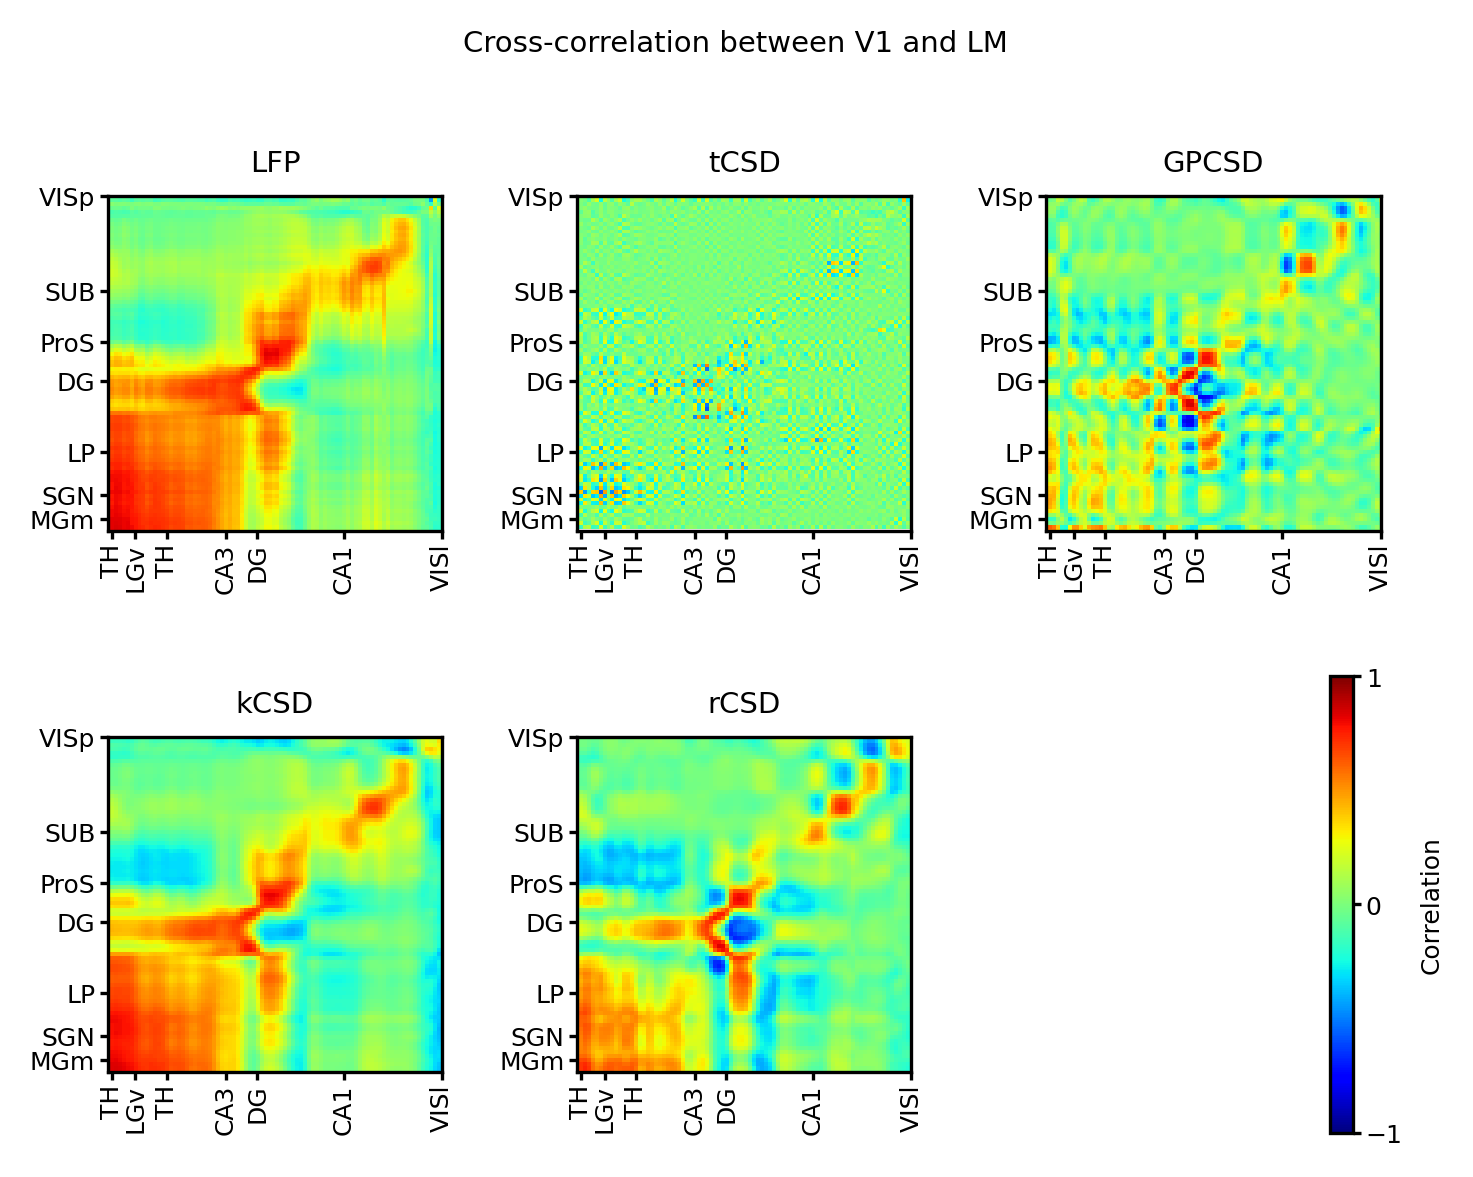

In [30]:
# Calculate cross-correlation between V1 and LM
utils.use_pdf_plot()

fig, axes = plt.subplots(2, 3, figsize=(5, 4), dpi=300)
fig.suptitle('Cross-correlation between V1 and LM')

methods = ['lfp', 'tcsd', 'gpcsd', 'kcsd', 'rcsd']
titles = ['LFP', 'tCSD', 'GPCSD', 'kCSD', 'rCSD']

for i, (method, title) in enumerate(zip(methods, titles)):

    # Calculate correlation matrix between V1 and LM
    cross_corr = cross_corr_dict[method]
    # cross_corr /= np.abs(cross_corr).max()
    
    # Plot correlation matrix
    row = i // 3
    col = i % 3
    im = axes[row, col].imshow(cross_corr, cmap='jet', vmin=-1, vmax=1)

    axes[row, col].set_xticks(results_dict['LM']['intervals'][1:-1].flatten())
    axes[row, col].set_xticklabels(results_dict['LM']['structure_acronyms'][:-1], rotation=90)
    axes[row, col].set_yticks(results_dict['V1']['intervals'][1:-1].flatten())
    axes[row, col].set_yticklabels(results_dict['V1']['structure_acronyms'][:-1])
    axes[row, col].set_title(title)
    axes[row, col].set_xlim(0, results_dict['LM']['intervals'][-2])
    axes[row, col].set_ylim(0, results_dict['V1']['intervals'][-2])

# Hide the empty subplot
axes[1, 2].axis('off')
cbar = fig.colorbar(im, ax=axes[1,2], label='Correlation', ticks=[-1, 0, 1])


plt.tight_layout()
plt.show()

f.savefig('figures/figure_4_allen_corr.pdf', bbox_inches='tight', dpi=300)

# Running vs stationary

In [32]:
running_trial_index = np.load('/home/qix/user_data/LFP/757216464_running_trial_index.npy')
selected_trial_index = np.logical_not(running_trial_index)
cross_corr_dict = {}

for behavior in ['stationary', 'running']:
    print(behavior)
    if behavior == 'stationary':
        selected_trial_index = np.logical_not(running_trial_index)
    else:
        selected_trial_index = running_trial_index
    results_dict = {}

    for probe in ['V1', 'LM']:
        if probe == 'V1':
            data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322749.npy', allow_pickle=True)
        else:
            data = np.load('/home/qix/user_data/LFP/lfp_757216464_769322751.npy', allow_pickle=True)

        data = data.item()  # Convert from np.ndarray to dict

        lfp = data['aligned_lfp3d'].values.transpose((0, 2, 1))
        # lfp = lfp.mean(axis=2)[:, :, None]

        x = data['locationA'][:, 0]      # LFP spatial locations , microns
        x = x[:, None]
        nx = len(x)
        # CSD spatial locations , microns
        z = x
        nz = nx

        # Smooth LFP along time axis using Gaussian filter
        from scipy.ndimage import gaussian_filter1d
        sigma = 2  # Adjust smoothing amount by changing sigma
        lfp_smoothed = np.zeros_like(lfp)
        for i in range(lfp.shape[0]):  # Loop over spatial dimension
            for j in range(lfp.shape[2]):  # Loop over trials
                lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)
        lfp_smoothed = normalize(lfp_smoothed)
        lfp = lfp_smoothed[:, :, selected_trial_index]

        nt = lfp.shape[1]
        t = np.arange(nt)
        t = t[:, None]

        ### rCSD
        R_true = 150
        lam_smooth = 1
        lam_region = 1e-2
        lam_lasso = 0.3e-1
        rcsd = rCSD.rCSD(lfp, z, x, boundary_depth=[860, 2500], 
                        R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
        rcsd_pred = rcsd.predict(parallel=False)
        # rcsd.get_difference()

        # Collect all LFP and CSD predictions in a dictionary
        results_dict[probe] = {
            'z': z,
            'lfp': lfp,
            'rcsd': rcsd_pred,
            'intervals': data['intervals'],
            'structure_acronyms': data['structure_acronyms']
        }


    method = 'rcsd'
    v1_data = results_dict['V1'][method].reshape(results_dict['V1'][method].shape[0], -1)
    lm_data = results_dict['LM'][method].reshape(results_dict['LM'][method].shape[0], -1)

    cross_corr = np.corrcoef(v1_data, lm_data)[0:v1_data.shape[0], v1_data.shape[0]:]

    cross_corr_dict[behavior] = cross_corr

stationary
running


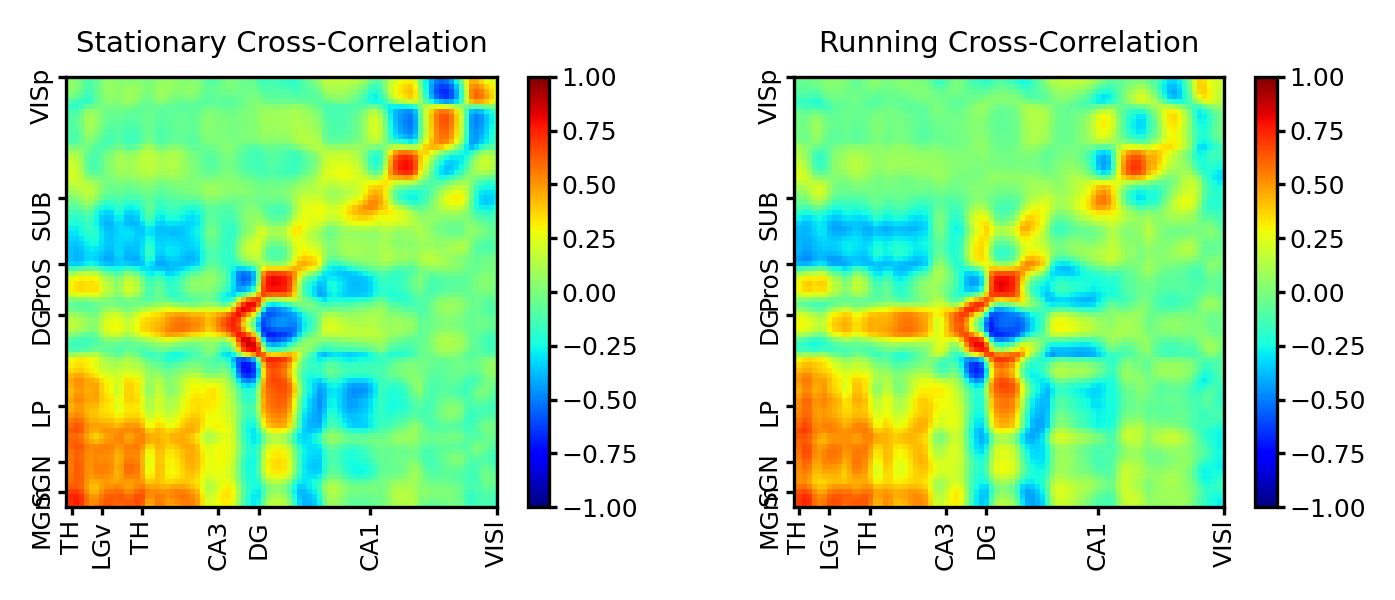

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(5,2))

im1 = ax1.imshow(cross_corr_dict['stationary'], cmap='jet', vmin=-1, vmax=1) 
ax1.set_title('Stationary Cross-Correlation')
plt.colorbar(im1, ax=ax1)
ax1.set_xticks(results_dict['LM']['intervals'][1:-1].flatten())
ax1.set_xticklabels(results_dict['LM']['structure_acronyms'][:-1], rotation=90)
ax1.set_yticks(results_dict['V1']['intervals'][1:-1].flatten())
ax1.set_yticklabels(results_dict['V1']['structure_acronyms'][:-1], rotation=90)
ax1.set_xlim(0, results_dict['LM']['intervals'][-2])
ax1.set_ylim(0, results_dict['V1']['intervals'][-2])

im2 = ax2.imshow(cross_corr_dict['running'], cmap='jet', vmin=-1, vmax=1)
ax2.set_title('Running Cross-Correlation')
plt.colorbar(im2, ax=ax2)
ax2.set_xticks(results_dict['LM']['intervals'][1:-1].flatten())
ax2.set_xticklabels(results_dict['LM']['structure_acronyms'][:-1], rotation=90)
ax2.set_yticks(results_dict['V1']['intervals'][1:-1].flatten())
ax2.set_yticklabels(results_dict['V1']['structure_acronyms'][:-1], rotation=90)
ax2.set_xlim(0, results_dict['LM']['intervals'][-2])
ax2.set_ylim(0, results_dict['V1']['intervals'][-2])
plt.tight_layout()

f.savefig('figures/figure_5_running_stationary_corr.pdf', bbox_inches='tight', dpi=300)